In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import qdatoolkit as qda

file_path = "C:/Users/Utente/Documents/PYTHON/QDA COURSE/PROJECT/qda-project/data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


Generate a temperature matrix

In [3]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [4]:
digits_round = 1
x_range = (26.264, 38.053)
y_range = (-66.506, -54.848)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df,layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_12964\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_12964\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [5]:
list_25l.shape

(25, 117, 118)

# Preliminary data manipolation:

Objective of the data modeling: identify points with anomalous temperature behavior in each layer.

Idea: performing layer-wise clustering of image data using PCA and K-means, and then extracting pixel information for the smallest and biggest clusters in each layer. Smallest and biggest clusters depend on the how a pixel was considered extreme in the principal component space.
A pixel was considered extreme if its value was far from the average or typical values in the dataset. After applying PCA, a pixel was considered extreme if it had a high Hotelling’s T² statistic, meaning it lied far from the center of the principal component space. These extreme points represented regions with anomalous temperature behavior compared to the rest of the pixels and were collected in a cluster called "Smallest Cluster". On the other hand, the pixels outside those regions were stored in "Biggest Cluster".
Given the clustering methodology employed, specifically utilizing Hotelling's T² statistic, the "Smallest Cluster" identified inherently represents the group exhibiting the most statistically anomalous multivariate observations. While a standardized analytical approach might prioritize the cluster with the highest average T² value, for the sake of computational ease and to facilitate a focused in-depth analysis of the most deviating data points, the "Smallest Cluster" was selected for further investigation.

In order to come up with a dataframe that helped in differentiating between smallest and biggest clusters, the following process was followed:
- Standardization before PCA: compulsory since the variables had different scales.
PCA is sensitive to the scale of the variables. If the input data are not standardized, variables with larger scales will dominate the principal components, leading to biased results.
- Application of PCA to reduce dimensionality
- Computation of the Hotelling’s T² statistic for each pixel, measuring how extreme each pixel was in the principal component space.
- Application of K-means clustering (with 2 clusters) to the T² values, segmenting the pixels into a group with points with less extremes values on the principal component space and another group with more extreme values. K-means clustering is also sensitive to scale. If T² values have a wide range or are skewed, clusters may be biased toward higher-magnitude values. For this reason, standardization of T² was required for ensuring that clustering was based on relative differences, not absolute magnitudes, making the clustering more robust and meaningful.

In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming list_25l is a numpy array of shape (25, 120, 118)
num_layers = list_25l.shape[0]
height = list_25l.shape[1]
width = list_25l.shape[2]
smallest_cluster_pixels = []
biggest_cluster_pixels = []

for i in range(num_layers):
    # Extract the current layer
    current_layer = list_25l[i, :, :]

    # Standardize the data before reshaping for PCA
    scaler_pca = StandardScaler()
    current_layer_scaled = scaler_pca.fit_transform(current_layer)

    # Reshape the standardized data for PCA
    X = current_layer_scaled.reshape(-1, 1)

    # Apply PCA
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X)

    # Compute Hotelling’s T² statistic for each pixel
    explained_variance = pca.explained_variance_
    if explained_variance[0] > 1e-8:
        T2 = (scores ** 2) / explained_variance[0]
    else:
        T2 = np.zeros_like(scores)

    # Standardize T2 values before K-means (optional but potentially useful)
    scaler_kmeans = StandardScaler()
    T2_scaled = scaler_kmeans.fit_transform(T2.reshape(-1, 1))

    # Apply K-means clustering on the T² map
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    clusters_flat = kmeans.fit_predict(T2_scaled)
    clusters_map = clusters_flat.reshape(height, width)

    # Calculate the size of each cluster
    unique_clusters, counts = np.unique(clusters_map, return_counts=True)
    cluster_sizes = dict(zip(unique_clusters, counts))

    # Find the label of the smallest and biggest cluster
    smallest_cluster_label = min(cluster_sizes, key=cluster_sizes.get)
    biggest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)

    # Extract the pixel coordinates and values for the smallest cluster
    smallest_cluster_indices = np.where(clusters_map == smallest_cluster_label)
    smallest_cluster_coords = list(zip(smallest_cluster_indices[0], smallest_cluster_indices[1]))
    smallest_cluster_values = current_layer_scaled[smallest_cluster_indices]
    smallest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": smallest_cluster_label,
        "pixel_coordinates": smallest_cluster_coords,
        "pixel_values": smallest_cluster_values
    })

    # Extract the pixel coordinates and values for the biggest cluster
    biggest_cluster_indices = np.where(clusters_map == biggest_cluster_label)
    biggest_cluster_coords = list(zip(biggest_cluster_indices[0], biggest_cluster_indices[1]))
    biggest_cluster_values = current_layer_scaled[biggest_cluster_indices]
    biggest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": biggest_cluster_label,
        "pixel_coordinates": biggest_cluster_coords,
        "pixel_values": biggest_cluster_values
    })

The "Smallest Cluster" was then matched with the original data list to give to each pixel the (x,y) coordinates and to specify the layer_id.

In [7]:
# Iterate through each layer's smallest cluster data
data = []
for layer_data in smallest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        data.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
high_T2_cluster = pd.DataFrame(data)
high_T2_cluster.head()

,x,y,temp_std,layer_id
0,0,0,2.732935,1
1,2,0,2.486629,1
2,4,0,2.301647,1
3,6,0,3.156023,1
4,7,0,1.891568,1


A chart was drawn to see how the extreme pixels with anomalous temperature behavior were distributed.

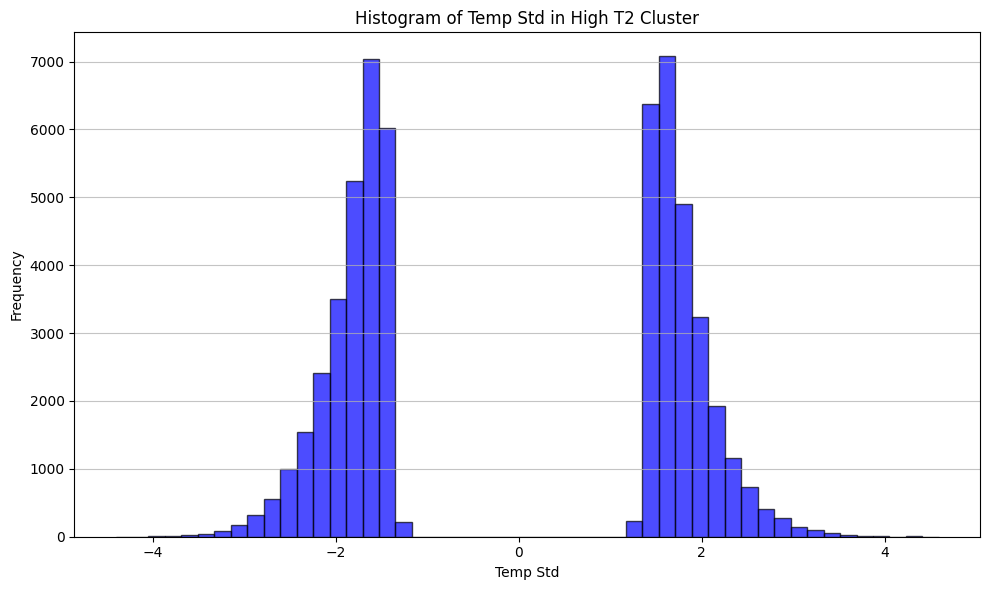

In [8]:
# Create a histogram of 'temp_std'
plt.figure(figsize=(10, 6))
plt.hist(high_T2_cluster['temp_std'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Temp Std')
plt.ylabel('Frequency')
plt.title('Histogram of Temp Std in High T2 Cluster')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

>The plot clearly stated that the standardized temperatures in the High Hotelling's T² statistic cluster was bimodal, signaling the presence of two distinct populations: cold and hot spots. Looking at the plot was clear that setting a threshold on Temp Std = 0 would have led to the creation of the two dataframes.

In [9]:
# Separate into cold_spots and hot_spots based on temp_std threshold
cold_spots = high_T2_cluster[high_T2_cluster['temp_std'] < 0].copy()
hot_spots = high_T2_cluster[high_T2_cluster['temp_std'] >= 0].copy()

# Reset indices for both DataFrames
cold_spots.reset_index(drop=True, inplace=True)
hot_spots.reset_index(drop=True, inplace=True)


# Followed Methodology for investigating the Temperatures of Cold and Hot Spots

Following the robust identification of hot and cold spot regions within each layer, the resulting two datasets underwent separate analyses employing identical methodological approaches. A general description of these two approaches is presented below, with detailed implementation provided in the subsequent script. The overarching objective of both approaches was to discern anomalies in hot and cold spot characteristics across different layers rather than within individual layers. For clarity of exposition, the methodological framework is initially outlined solely for cold spots; the identical procedure was subsequently applied to the hot spot data.

### First Approach:
A preliminary "quick & dirty" approach involved calculating the mean cold spot temperature for each layer, yielding a vector of 25 values representing the average cold spot intensity per layer. This method offers computational efficiency and ease of interpretation. However, its reliability is limited by the potential to mask significant intra-layer variability. Averaging across numerous data points within a layer can obscure the presence of outliers and fail to adequately represent the underlying data dispersion.

### Second Approach:
A more granular second approach focused on investigating cold spots within spatially consistent regions across the different layers. This methodology also relied on calculating the mean cold spot temperature within each defined area for every layer. However, it significantly reduced the dimensionality of the dataset, thereby enhancing the visibility of specific anomalies. Furthermore, this approach offers improved interpretability; the detection of an outlier allows the machine operator to readily identify the specific area and layer contributing to the data anomaly. The first approach only provided an indication of an anomaly at the layer level, lacking the spatial specificity of this second method. Notably, the identification of the nine distinct areas was based on ensuring a comparable number of cold spots within each area across different layers, rather than uniform spatial dimensions in the x-y plane. This strategy aimed to mitigate potential biases in the inter-layer comparison of mean values within corresponding regions arising from substantial variations in the number of data points per area.
For the sake of simplicity and as an initial step in the analysis, the layer was discretized into nine distinct regions. However, the increasing number of defined areas would enhance the granularity of the investigation, thereby facilitating the identification of more specific sub-regions exhibiting anomalous characteristics.



Note: Regular points were treated differently. The approach can be found below the second method.

# First Approach: Cold Spots Analysis

To analyze how Cold Spots behave, a first plot on the pattern of the data was required. Moreover, to start designing control charts, the assumptions of normality and independence were checked.

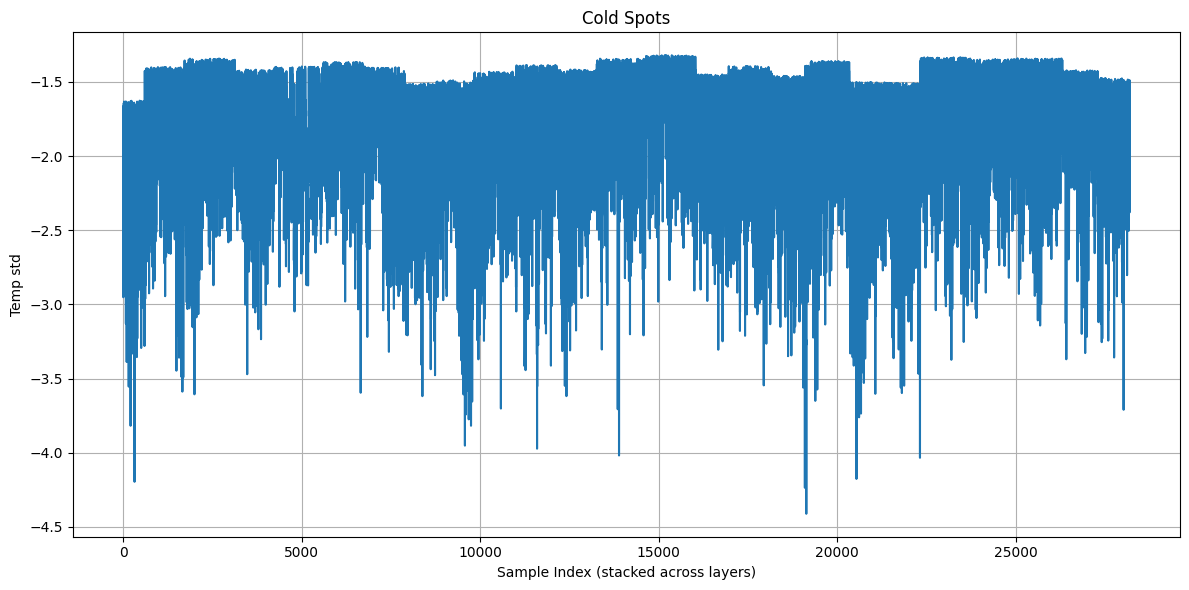

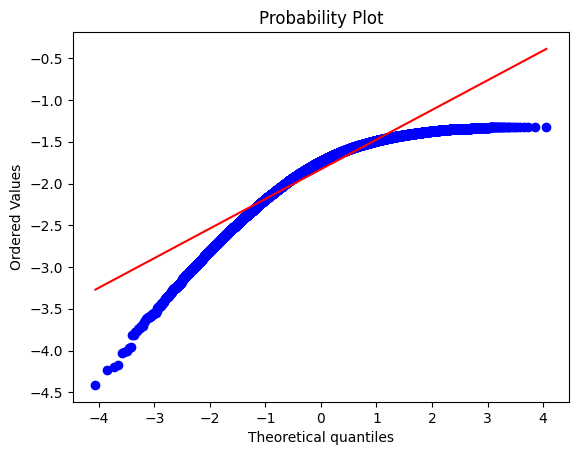

c:\Users\Utente\Documents\PYTHON\envs\qda\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.897
Shapiro-wilk test p-value = 0.000
Runs test statistic = -36.395
Runs test p-value = 0.000



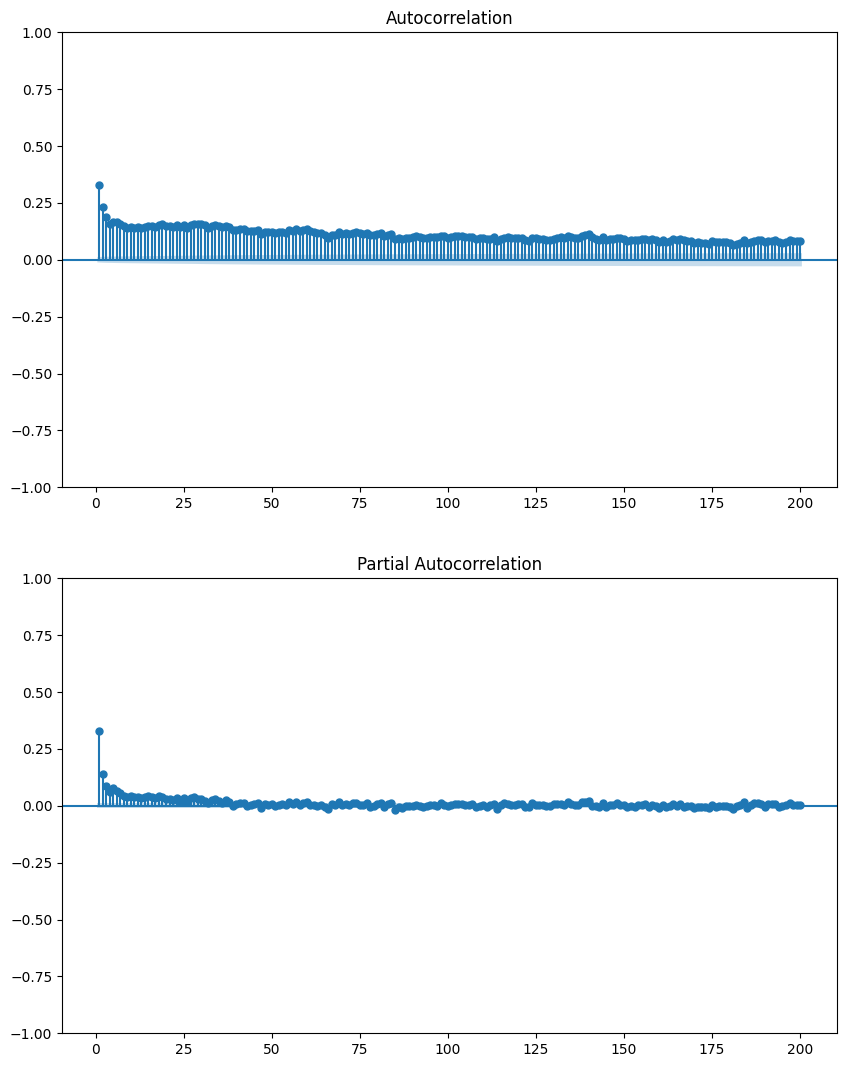

In [10]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(cold_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Cold Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(cold_spots['temp_std']).normality()  # Normality check
_ = qda.Assumptions(cold_spots['temp_std']).independence()  # Indipendence check

>As suggested by the plots, both normality and independence assumptions are clearly unmet, suggesting that a further data modeling was required.

Since the approach aimed in taking the average values of the standardized temperatures of the Cold Spots inside each layer, the higher constraint was the normality assumption, since the indipendence would not have been a problem after the mean computation.
For this reason, Box Cox transformation was applied to the temperature values. 

io scriverei semplicemente che un primo approccio per trovare la normalità è usare boxcox

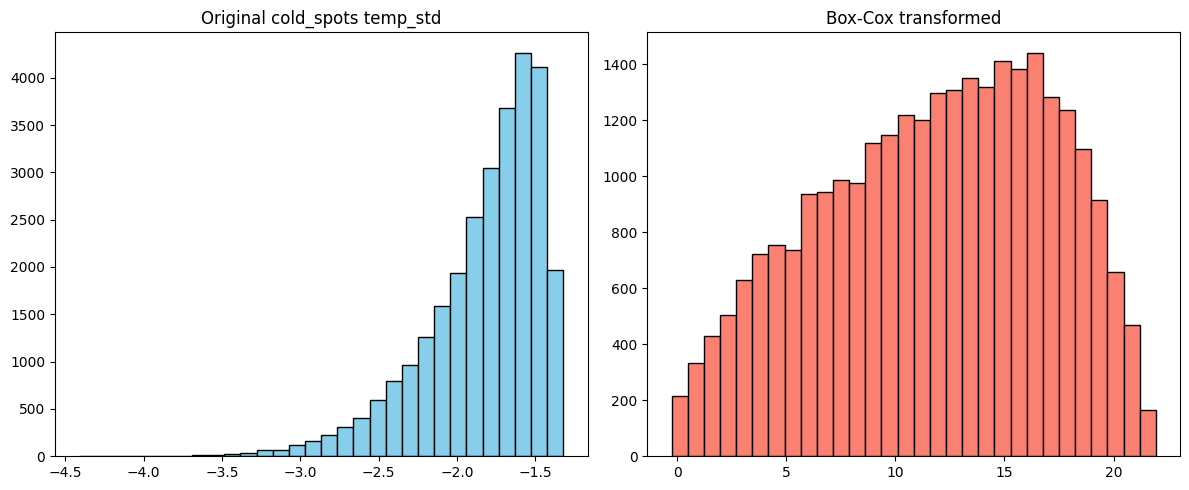

c:\Users\Utente\Documents\PYTHON\envs\qda\lib\site-packages\qdatoolkit\models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


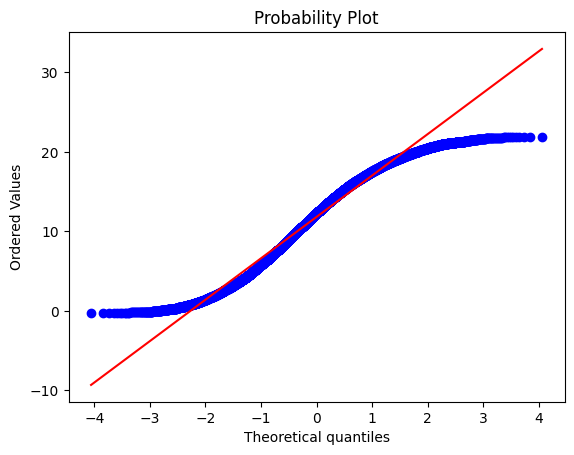

Shapiro-wilk test statistic = 0.973
Shapiro-wilk test p-value = 0.000


In [11]:
from scipy.stats import boxcox, normaltest

# Box-Cox requires values > 0: the data were shifted to be positive
min_val_cs = cold_spots['temp_std'].min()
if min_val_cs <= 0:
    shift = abs(min_val_cs) + 1e-6
else:
    shift = 0

temp_shifted_cs = cold_spots['temp_std'] + shift
temp_boxcox_cs, fitted_lambda_cs = boxcox(temp_shifted_cs)
cold_spots['temp_boxcox_cs'] = temp_boxcox_cs

# Comparison plot: before and after Box-Cox transformation
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(cold_spots['temp_std'], bins=30, color='skyblue', edgecolor='k')
plt.title('Original cold_spots temp_std')
plt.subplot(1,2,2)
plt.hist(temp_boxcox_cs, bins=30, color='salmon', edgecolor='k')
plt.title('Box-Cox transformed')
plt.tight_layout()
plt.show()

# Check of normality assumption
_=qda.Assumptions(temp_boxcox_cs).normality()  

>The data were not still normally distributed

The mean of the standardized temperature were computed to check their pattern on time.

qui inserirei che riducendo il dataset, è possibile trovare anche le assumptions.

In [12]:
# Compute the mean of 'temp_std' for cold spots per layer
cold_spots_mean_per_layer = cold_spots.groupby('layer_id')['temp_boxcox_cs'].mean().values
print(cold_spots_mean_per_layer)

[ 8.61656895 11.54519271 12.72228607 11.99246946 10.73453914 13.48298494
 11.58018447 10.43142348  9.23008125 10.56394341 12.23476517 11.5793012
 13.84376533 14.07120718 11.42559261 10.86330124 11.4093531  12.62592967
  8.97818867 10.02075836 13.00311833 13.12743728 13.50968116 12.13864926
 11.36908801]


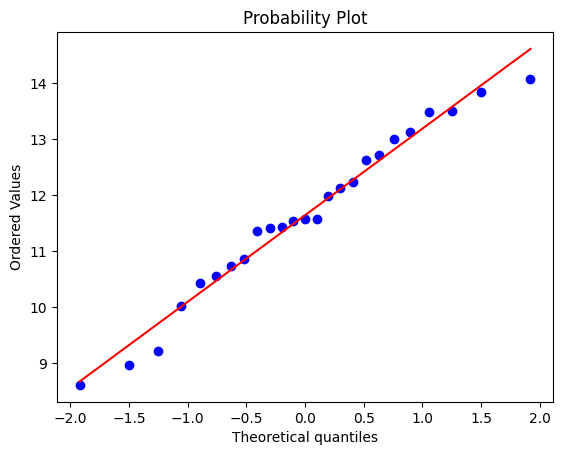

Shapiro-wilk test statistic = 0.970
Shapiro-wilk test p-value = 0.653
Runs test statistic = -0.133
Runs test p-value = 0.894



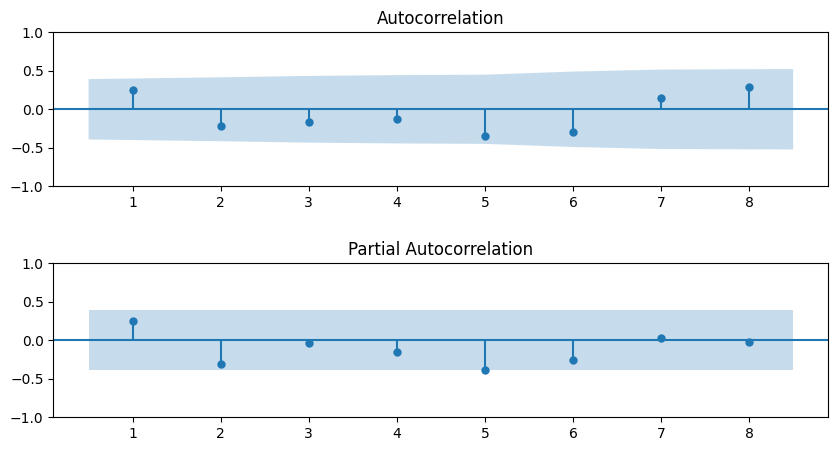

In [13]:
_=qda.Assumptions(cold_spots_mean_per_layer).normality()  # Normality check
_=qda.Assumptions(cold_spots_mean_per_layer).independence()  # Indipendence check

>Both assumptions were met allowing the design of the I-MR Control Chart.

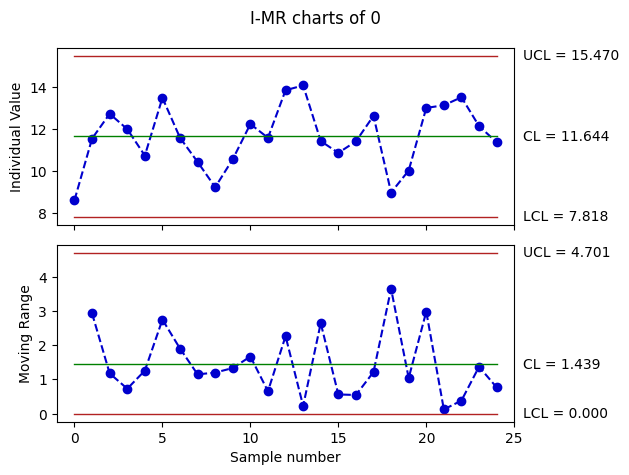

In [14]:
# DataFrame for the residuals
df_SCC_cts = pd.DataFrame(cold_spots_mean_per_layer, columns=['0'])

# I-MR control chart
df_SCC_IMR_cts = qda.ControlCharts.IMR(df_SCC_cts, '0')

>No Out Of Control were detected but the points shown in the Moving Range Control Chart suggested that the Upper Control Limit was probably too far from the points.

io non lo scriverei dell'ucl, una frase scritta così può non aver molto significato: perchè allora non abbiamo fatto altre carte se riteniamo che ucl sia troppo distante?

>As stated before, this "quick & dirty" approach has a clear lack : considering the mean of high quantity of data has the effect of cut the variability of the data, not allowing the anomalies identification.

# First Approach: Hot Spots Analysis

As stated before, the same methodology was applied to Hot Spots

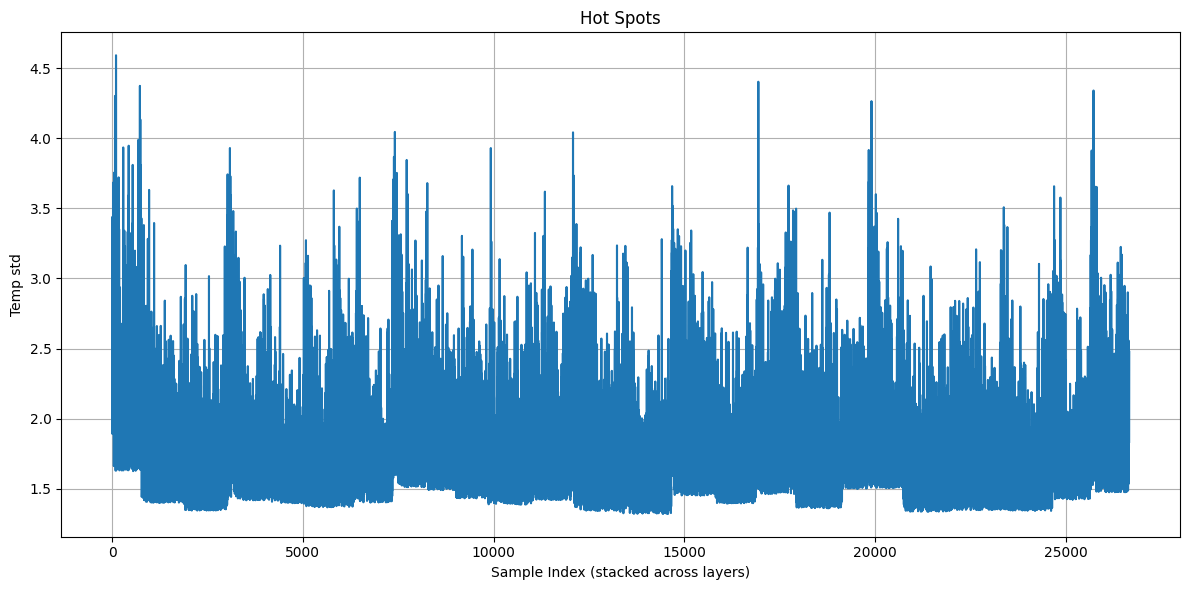

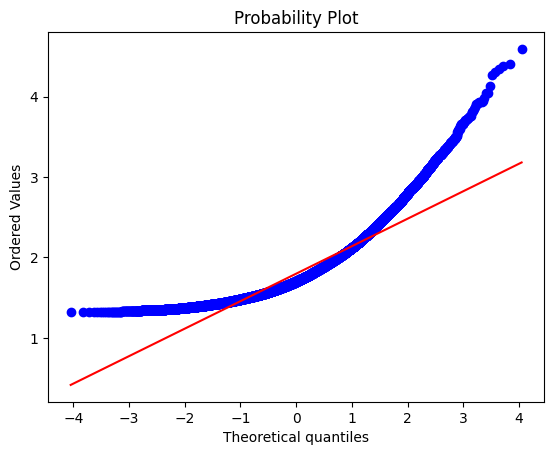

Shapiro-wilk test statistic = 0.870
Shapiro-wilk test p-value = 0.000
Runs test statistic = -28.181
Runs test p-value = 0.000



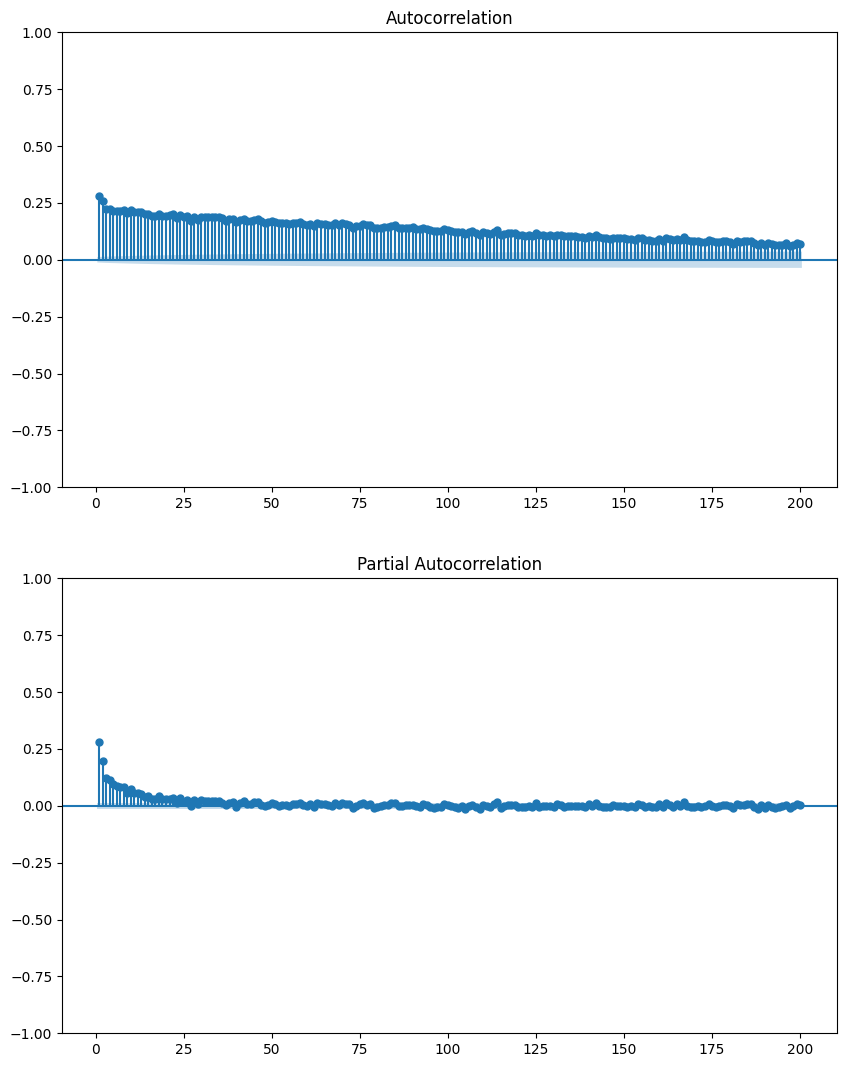

In [15]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(hot_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Hot Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(hot_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(hot_spots['temp_std']).independence()  # Controllo di indipendenza

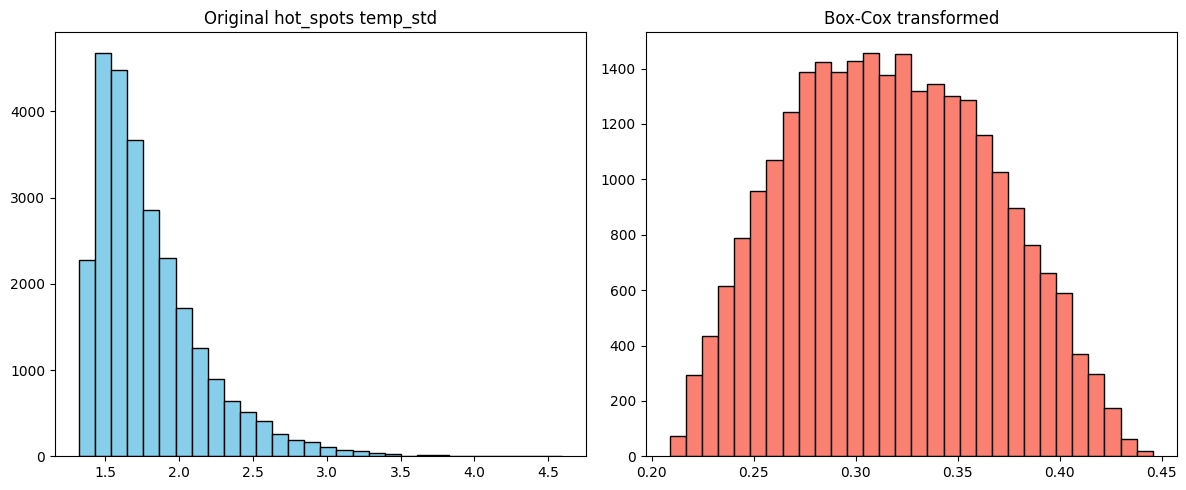

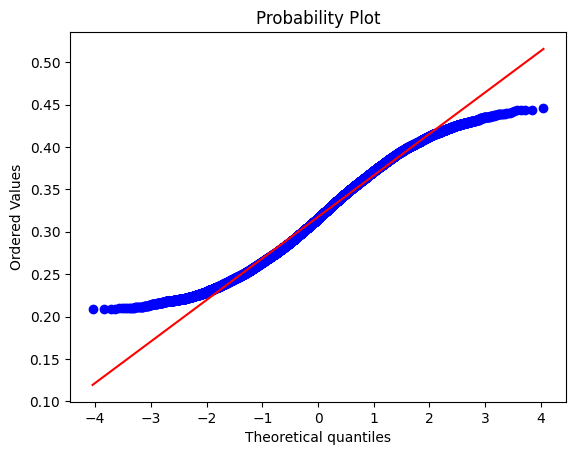

Shapiro-wilk test statistic = 0.986
Shapiro-wilk test p-value = 0.000


In [16]:
# Box-Cox transformation for on temperatures
temp_boxcox_hs, fitted_lambda_hs = boxcox(hot_spots['temp_std'])
hot_spots['temp_boxcox_hs'] = temp_boxcox_hs

# Comparison plot: before and after
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(hot_spots['temp_std'], bins=30, color='skyblue', edgecolor='k')
plt.title('Original hot_spots temp_std')
plt.subplot(1,2,2)
plt.hist(temp_boxcox_hs, bins=30, color='salmon', edgecolor='k')
plt.title('Box-Cox transformed')
plt.tight_layout()
plt.show()

_=qda.Assumptions(temp_boxcox_hs).normality() 

In [17]:
# Compute the mean of 'temp_std' for cold spots per layer
hot_spots_mean_per_layer = hot_spots.groupby('layer_id')['temp_boxcox_hs'].mean().values
print(hot_spots_mean_per_layer)

[0.36470816 0.31182231 0.29746129 0.32798539 0.30215127 0.31716886
 0.31108911 0.34518391 0.32102082 0.31515258 0.31018916 0.32167299
 0.30832101 0.30134853 0.33520434 0.30607912 0.33598466 0.30237582
 0.32443831 0.34210906 0.2941318  0.30764554 0.3069588  0.32354142
 0.3426973 ]


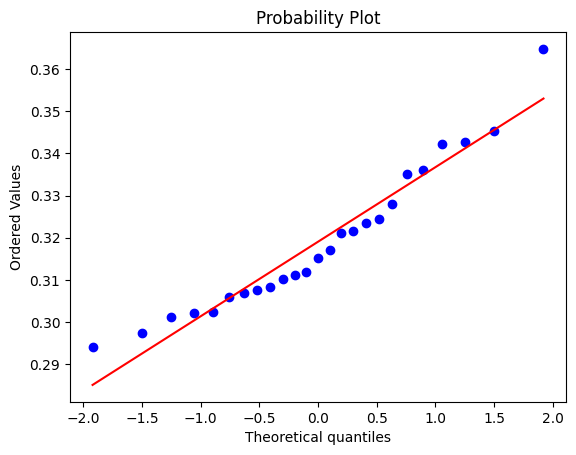

Shapiro-wilk test statistic = 0.939
Shapiro-wilk test p-value = 0.139
Runs test statistic = 0.697
Runs test p-value = 0.486



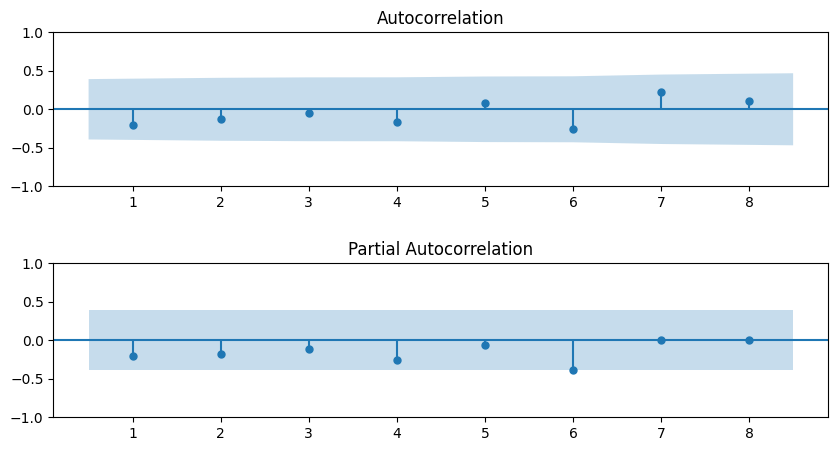

In [18]:
_=qda.Assumptions(hot_spots_mean_per_layer).normality()  # Controllo di normalità
_=qda.Assumptions(hot_spots_mean_per_layer).independence()  # Controllo di indipendenza

>Both assumptions were met allowing the design of the I-MR Control Chart.

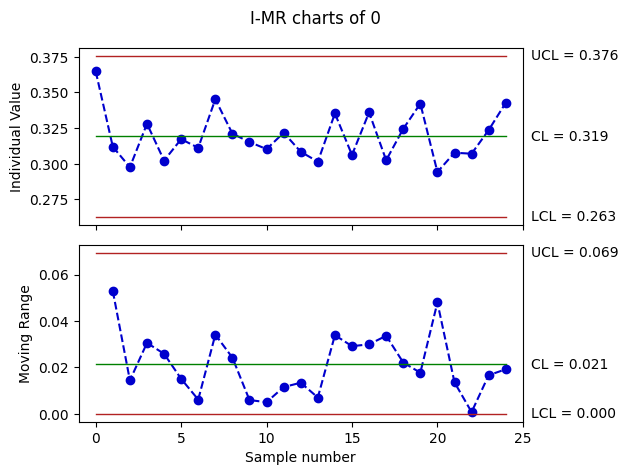

In [19]:
# DataFrame for the residuals
df_SCC_ths = pd.DataFrame(hot_spots_mean_per_layer, columns=['0'])

# I-MR control chart
df_SCC_IMR_ths = qda.ControlCharts.IMR(df_SCC_ths, '0')

>No Out Of Control were detected

# Second Approach: Cold Spots Analysis

Firstly, the x,y space is split into 9 areas with a similar number of cold spots.

In [ ]:
# Split x and y into 3 intervals each (3x3=9 areas) with the similar number of points per area
x_area_cs, x_bins_cs = pd.qcut(cold_spots['x'], q=3, labels=False, retbins=True, duplicates='drop')
y_area_cs, y_bins_cs = pd.qcut(cold_spots['y'], q=3, labels=False, retbins=True, duplicates='drop')

# Compute area_id (1-9) based on the position in the 3x3 grid
cold_spots['area_id'] = (y_area_cs * 3 + x_area_cs + 1).astype(int)

cold_spots.head()

,x,y,temp_std,layer_id,temp_boxcox_cs,area_id
0,56,1,-1.737914,1,12.227082,2
1,62,1,-1.816186,1,10.839292,2
2,68,2,-2.182259,1,5.815117,2
3,48,3,-2.951796,1,0.878730,2
4,53,4,-1.808503,1,10.970145,2


In [21]:
# Count the number of points in each area
area_counts = cold_spots['area_id'].value_counts().sort_index()
print(area_counts)

1    3036
2    2743
3    3670
4    3310
5    3095
6    3232
7    3197
8    3472
9    2438
Name: area_id, dtype: int64


The cold spot temperature values were plotted on those 9 areas.

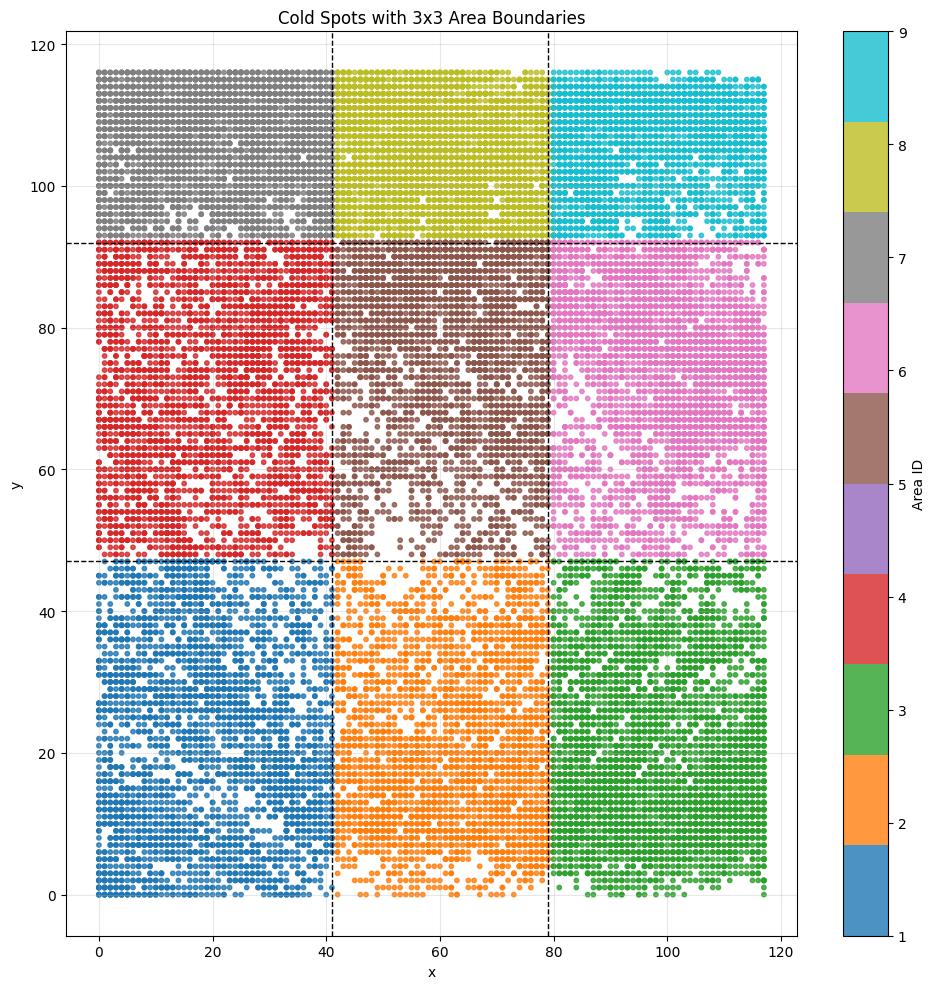

In [22]:
# Plot cold_spots with 3x3 area boundaries

plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    cold_spots['x'], cold_spots['y'],
    c=cold_spots['area_id'], cmap='tab10', s=10, alpha=0.8
)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cold Spots with 3x3 Area Boundaries')
plt.colorbar(scatter, ticks=range(1, 10), label='Area ID')

# Draw grid lines for area boundaries
for xb in x_bins_cs[1:-1]:
    plt.axvline(x=xb, color='k', linestyle='--', linewidth=1)
for yb in y_bins_cs[1:-1]:
    plt.axhline(y=yb, color='k', linestyle='--', linewidth=1)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

>As it can be clearly see in the figure, the 9 areas have different surfaces

In each area the mean of the temperature was calculated

In [23]:
# Computes the mean temperature (temp_std) for each area_id and layer_id in cold_spots
area_layer_mean_cs = cold_spots.groupby(['area_id', 'layer_id'])['temp_boxcox_cs'].mean().unstack()
print("Cold spots - Media temp_std per area e layer:")
print(area_layer_mean_cs)

Cold spots - Media temp_std per area e layer:
layer_id         1          2          3          4          5          6   \
area_id                                                                      
1          8.104508  10.858552  15.489424  12.378603  14.547300  13.458570   
2          9.137119  13.135493  11.558522  12.908801        NaN  15.069269   
3          8.666960  12.808101  11.394679  14.601040  18.707986        NaN   
4          8.306191  13.611429  15.416362  10.970168  14.349038  14.775581   
5          8.373621  12.409059  13.402387  11.781365  16.541423  12.747940   
6          8.591180  12.894886  16.720709  12.534596  14.321174  15.084114   
7          8.002667  14.677913  14.186228  12.183945   9.638437  14.440613   
8         10.208353  11.558209  15.233062  12.110897   9.734175  12.265010   
9          9.514084   8.988793        NaN  12.107988  10.693940  13.346831   

layer_id         7          8          9          10  ...         16  \
area_id                

All the results were merged in a single array where the the Not a Number (NaN) values were removed to not distort the results.
This simplified approach inherently yields a sparser representation within the data array but offers significant computational efficiency. A more sophisticated methodology could have involved the estimation of missing values through interpolation techniques based on the characteristics of proximal data points.
Indipendence and Normality assumptions were checked.


i nan non li abbiamo rimossi, semplicemente non sono plottati nel cc

c:\Users\Utente\Documents\PYTHON\envs\qda\lib\site-packages\qdatoolkit\models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


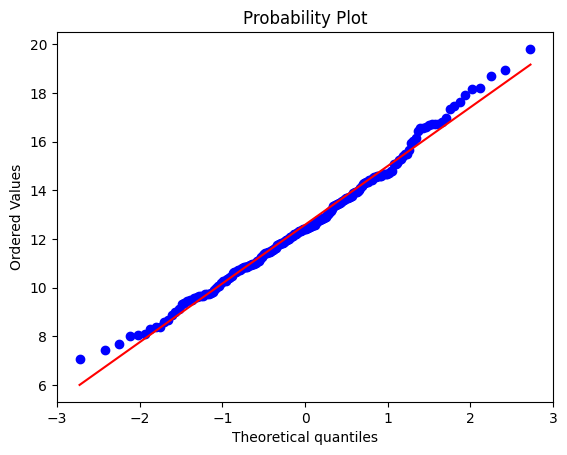

Shapiro-wilk test statistic = 0.990
Shapiro-wilk test p-value = 0.123
Runs test statistic = -0.936
Runs test p-value = 0.349



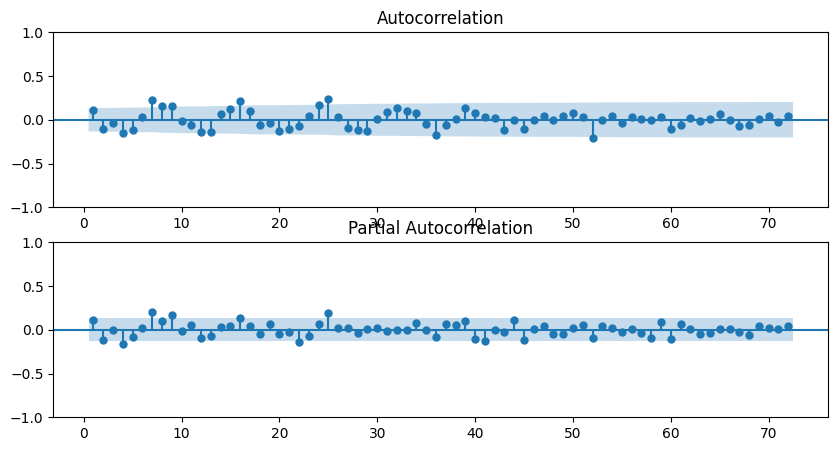

In [24]:
# Merge all area-layer means into a single array for cold_spots (Box-Cox transformed)
all_area_layer_means_cs = area_layer_mean_cs.values.flatten()

# Remove NaN values (some area-layer combinations may not have data)
all_area_layer_means_cs = all_area_layer_means_cs[~np.isnan(all_area_layer_means_cs)]

_ = qda.Assumptions(all_area_layer_means_cs).normality()
_ = qda.Assumptions(all_area_layer_means_cs).independence()

>Both assumptions were met

Design of the I-MR Control Chart on all_area_layer_means_cs dataframe

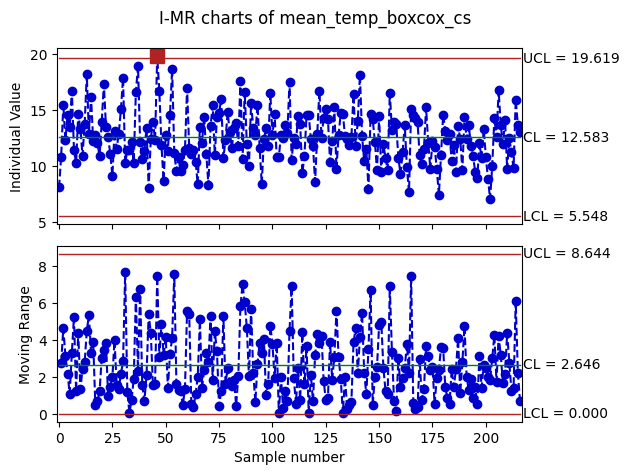

In [25]:
# Dataframe for designing the control chart
df_all_area_layer_means_cs = pd.DataFrame(all_area_layer_means_cs, columns=['mean_temp_boxcox_cs'])

# Control chart I-MR on the Box-Cox transformed data
_ = qda.ControlCharts.IMR(df_all_area_layer_means_cs, 'mean_temp_boxcox_cs')

codice per trovare dopo appartiene l'ooc

In [ ]:
# Identify the index of the point out of control in the I-MR chart for cold spots (all_area_layer_means_cs)
# The control limits are stored in df_all_area_layer_means_cs after running qda.ControlCharts.IMR

# Get the control limits from the I-MR chart object
ucl = df_all_area_layer_means_cs['mean_temp_boxcox_cs'].mean() + 3 * df_all_area_layer_means_cs['mean_temp_boxcox_cs'].std()
lcl = df_all_area_layer_means_cs['mean_temp_boxcox_cs'].mean() - 3 * df_all_area_layer_means_cs['mean_temp_boxcox_cs'].std()

# Find indices of points out of control
out_of_control_indices = df_all_area_layer_means_cs[
    (df_all_area_layer_means_cs['mean_temp_boxcox_cs'] > ucl) | 
    (df_all_area_layer_means_cs['mean_temp_boxcox_cs'] < lcl)
].index.tolist()

print("Indices of points out of control:", out_of_control_indices)

# Map these indices back to area_id and layer_id
area_layer_pairs = list(area_layer_mean_cs.stack().index)
out_of_control_info = []
for idx in out_of_control_indices:
    if idx < len(area_layer_pairs):
        area_id, layer_id = area_layer_pairs[idx]
        out_of_control_info.append({'index': idx, 'area_id': area_id, 'layer_id': layer_id})

print("Out of control points (index, area_id, layer_id):")
for info in out_of_control_info:
    print(info)

>One out of control point was found in the I-Chart. Specifically, the point came out from the layer ... in the area ... (upper/lower left/right). 

# Second Approach: Hot Spots Analysis

As stated before, the same methodology was applied to Hot Spots

In [ ]:
# Split x and y into 3 intervals each (3x3=9 areas) with the same number of points per area
x_area_hs, x_bins_hs = pd.qcut(hot_spots['x'], q=3, labels=False, retbins=True, duplicates='drop')
y_area_hs, y_bins_hs = pd.qcut(hot_spots['y'], q=3, labels=False, retbins=True, duplicates='drop')

# Compute area_id (1-9) based on the position in the 3x3 grid
hot_spots['area_id'] = (y_area_hs * 3 + x_area_hs + 1).astype(int)

In [27]:
# Count the number of points in each area
area_counts = hot_spots['area_id'].value_counts().sort_index()
print(area_counts)

1    2622
2    3078
3    3224
4    3023
5    3250
6    2616
7    3471
8    2432
9    2946
Name: area_id, dtype: int64


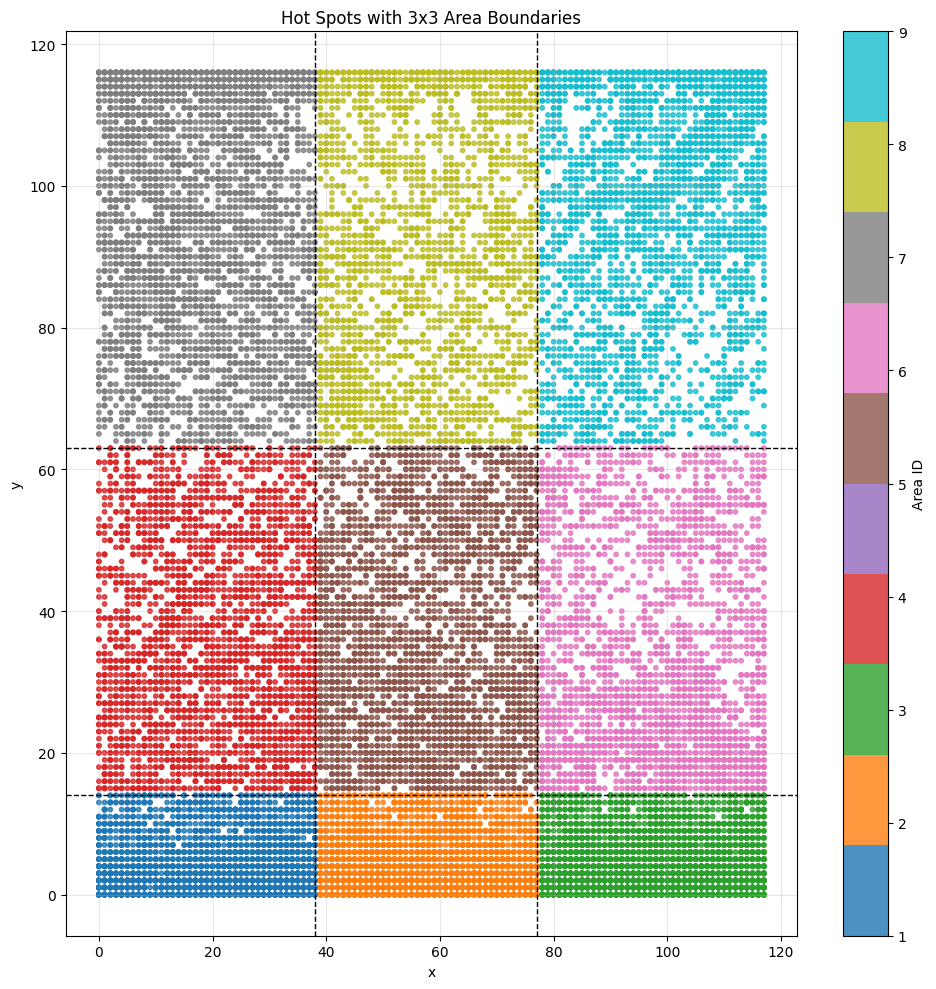

In [28]:
# Plot hot_spots con i confini delle 9 aree (3x3)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    hot_spots['x'], hot_spots['y'],
    c=hot_spots['area_id'], cmap='tab10', s=10, alpha=0.8
)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Hot Spots with 3x3 Area Boundaries')
plt.colorbar(scatter, ticks=range(1, 10), label='Area ID')

# Draw grid lines for area boundaries (hot spots)
for xb in x_bins_hs[1:-1]:
    plt.axvline(x=xb, color='k', linestyle='--', linewidth=1)
for yb in y_bins_hs[1:-1]:
    plt.axhline(y=yb, color='k', linestyle='--', linewidth=1)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Computes the mean temperature (temp_std) for each area_id and layer_id in hot spots
area_layer_mean_hs = hot_spots.groupby(['area_id', 'layer_id'])['temp_boxcox_hs'].mean().unstack()
print("Hot spots - Media temp_boxcox per area e layer:")
print(area_layer_mean_hs)


Hot spots - Media temp_boxcox per area e layer:
layer_id        1         2         3         4         5         6   \
area_id                                                                
1         0.371030       NaN  0.295043  0.331624  0.311958  0.338184   
2         0.370545  0.338990  0.316584  0.335875  0.290397  0.325309   
3         0.371798  0.325685  0.291962  0.342134  0.325540  0.321061   
4         0.350457  0.302028  0.299411  0.318749  0.289866  0.301809   
5         0.369683  0.312257  0.291645  0.306872  0.275636  0.312222   
6         0.348101  0.317535  0.281647  0.293877  0.300534  0.289616   
7         0.369680  0.305309  0.285601  0.329159  0.301953  0.321815   
8         0.359406  0.309860  0.296233  0.320182  0.261621  0.321615   
9         0.362108  0.315577  0.298978  0.313856  0.288398       NaN   

layer_id        7         8         9         10  ...        16        17  \
area_id                                           ...                       
1    

c:\Users\Utente\Documents\PYTHON\envs\qda\lib\site-packages\qdatoolkit\models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


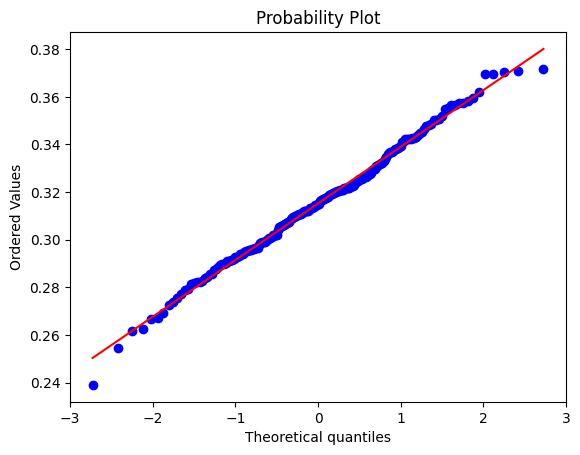

Shapiro-wilk test statistic = 0.995
Shapiro-wilk test p-value = 0.676
Runs test statistic = -0.135
Runs test p-value = 0.893



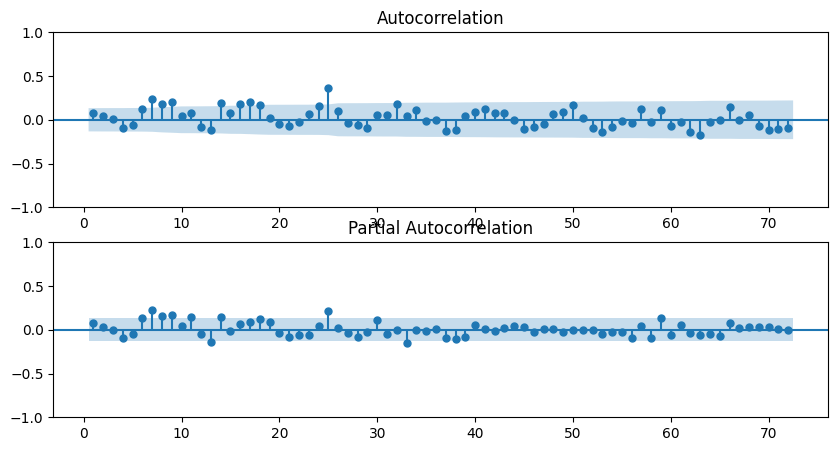

In [30]:
# Merge all area-layer means into a single array for cold_spots (Box-Cox transformed)
all_area_layer_means_hs = area_layer_mean_hs.values.flatten()

# Remove NaN values (some area-layer combinations may not have data)
all_area_layer_means_hs = all_area_layer_means_hs[~np.isnan(all_area_layer_means_hs)]

# Check normality and independence assumptions
_ = qda.Assumptions(all_area_layer_means_hs).normality()
_ = qda.Assumptions(all_area_layer_means_hs).independence()

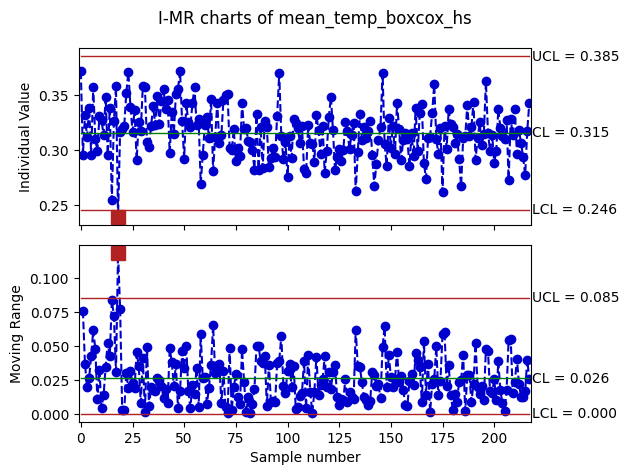

In [31]:
# DataFrame per il control chart
df_all_area_layer_means_hs = pd.DataFrame(all_area_layer_means_hs, columns=['mean_temp_boxcox_hs'])

# Control chart I-MR su tutti i valori Box-Cox trasformati
_ = qda.ControlCharts.IMR(df_all_area_layer_means_hs, 'mean_temp_boxcox_hs')

In [ ]:
# Identify the index of the point out of control in the I-MR chart for cold spots (all_area_layer_means_hs)
# The control limits are stored in df_all_area_layer_means_hs after running qda.ControlCharts.IMR

# Get the control limits from the I-MR chart object
ucl = df_all_area_layer_means_hs['mean_temp_boxcox_hs'].mean() + 3 * df_all_area_layer_means_hs['mean_temp_boxcox_hs'].std()
lcl = df_all_area_layer_means_hs['mean_temp_boxcox_hs'].mean() - 3 * df_all_area_layer_means_hs['mean_temp_boxcox_hs'].std()

# Find indices of points out of control
out_of_control_indices = df_all_area_layer_means_hs[
    (df_all_area_layer_means_hs['mean_temp_boxcox_hs'] > ucl) | 
    (df_all_area_layer_means_hs['mean_temp_boxcox_hs'] < lcl)
].index.tolist()

print("Indices of points out of control:", out_of_control_indices)

# Map these indices back to area_id and layer_id
area_layer_pairs = list(area_layer_mean_hs.stack().index)
out_of_control_info = []
for idx in out_of_control_indices:
    if idx < len(area_layer_pairs):
        area_id, layer_id = area_layer_pairs[idx]
        out_of_control_info.append({'index': idx, 'area_id': area_id, 'layer_id': layer_id})

print("Out of control points (index, area_id, layer_id):")
for info in out_of_control_info:
    print(info)

>The same One Out Of Control point was found in both the I and MR Control Chart. The point corresponds to the mean of the temperature values in the layer ... in the area ...

# Regular Points Analysis

Finally, the regular data points, categorized within the "Biggest Cluster" during the data manipulation phase, were also subjected to analysis. These points, ideally exhibiting neither cold nor hot spot characteristics, should represent the baseline temperature distribution. Consequently, the identification of out-of-control signals within this cluster suggests a potential anomaly in the temperature measurement or identification process itself.

A dataframe represented the regular points was created by the Biggest Cluster

In [32]:
# Iterate through each layer's biggest cluster data
regular_data_list = []
for layer_data in biggest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        regular_data_list.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
regular_data = pd.DataFrame(regular_data_list)
regular_data.head()

,x,y,temp_std,layer_id
0,1,0,1.368609,1
1,3,0,0.606690,1
2,5,0,0.475641,1
3,9,0,1.329965,1
4,11,0,0.945900,1


Given the high dimensionality of the initial dataset, a gap processing methodology was implemented to manage computational resources effectively. This involved subsampling the data by selecting approximately one data point out of every five.

In [ ]:
# Gapping on the regular_data DataFrame by keeping 1 row every 5
generate_temperature_matrices_v1_size = 5
gapped_data = regular_data.iloc[::5].reset_index(drop=True)
gapped_data.head() 

,x,y,temp_std,layer_id
0,1,0,1.368609,1
1,13,0,0.973318,1
2,25,0,-0.714688,1
3,34,0,1.174879,1
4,41,0,0.929085,1


Normality and Indipendence assumptions were checked on the new dataframe

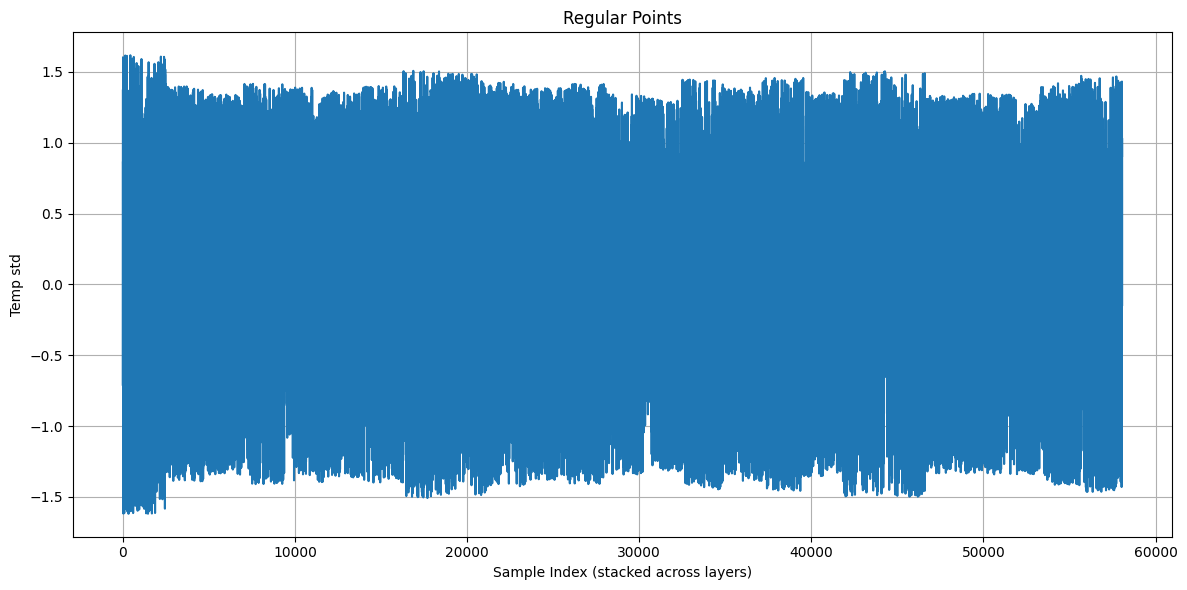

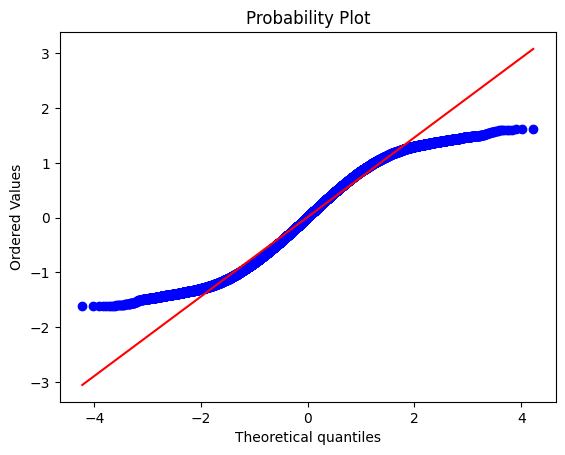

c:\Users\Utente\Documents\PYTHON\envs\qda\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.976
Shapiro-wilk test p-value = 0.000
Runs test statistic = -38.260
Runs test p-value = 0.000



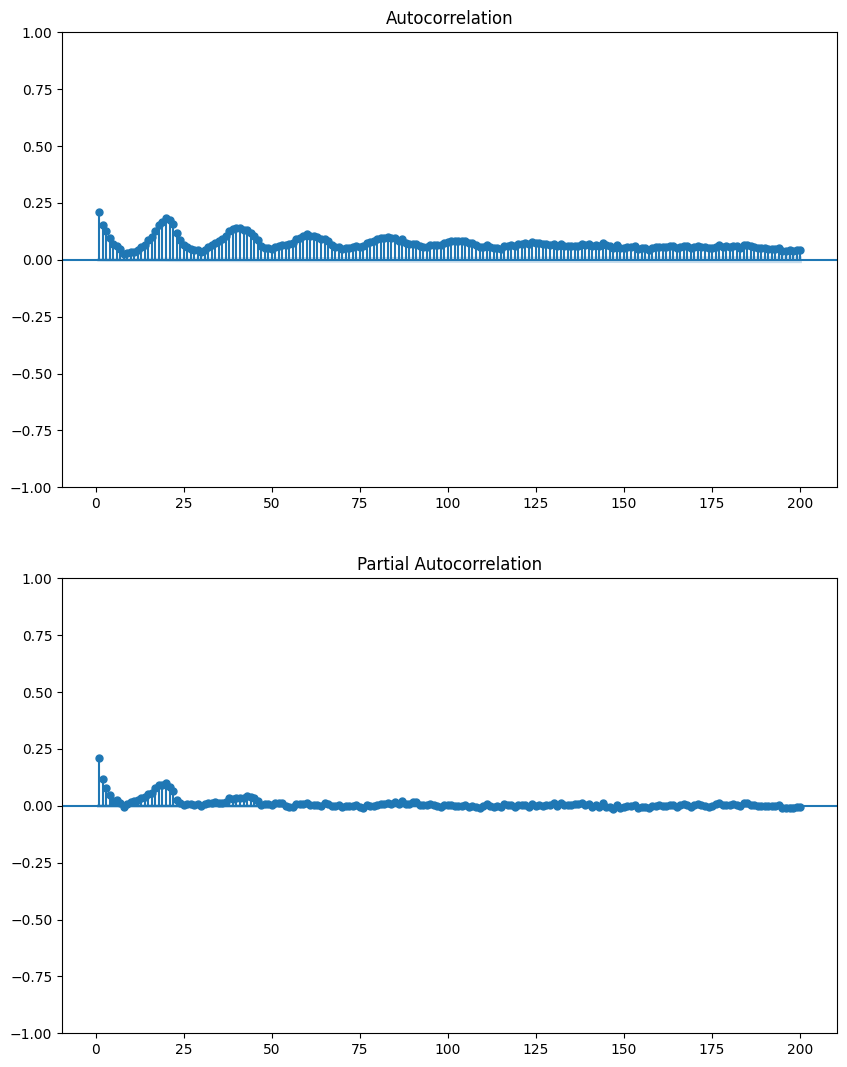

In [34]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(gapped_data['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Regular Points')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(gapped_data['temp_std']).normality()
_ = qda.Assumptions(gapped_data['temp_std']).independence()  

>The findings indicated a violation of the underlying statistical assumptions. Furthermore, the dimensionality of the dataset remained a significant factor, potentially hindering further analysis and interpretation.

Since the objective was to find the mean of the temperature values of the regular points in each layer, the mean values were computed and the assumptions were re-checked

In [35]:
regular_point_mean_per_layer = gapped_data.groupby('layer_id')['temp_std'].mean().values
print(regular_point_mean_per_layer)

[-0.04330063  0.02659924  0.06624767 -0.00830716  0.10003022 -0.02831249
  0.02571578 -0.02860079  0.07535003  0.06673455  0.01556395  0.03782593
  0.00938679  0.00152004 -0.03344583  0.03168277 -0.03037192  0.02592663
  0.0592009  -0.00358962  0.04613031 -0.01127972 -0.01064076 -0.00497811
 -0.03870691]


c:\Users\Utente\Documents\PYTHON\envs\qda\lib\site-packages\qdatoolkit\models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


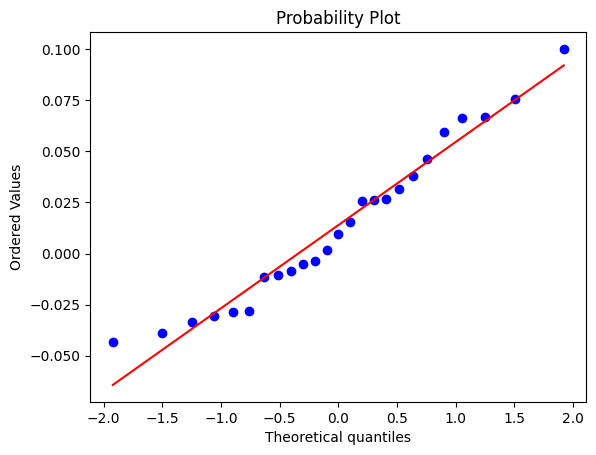

Shapiro-wilk test statistic = 0.957
Shapiro-wilk test p-value = 0.354
Runs test statistic = 0.622
Runs test p-value = 0.534



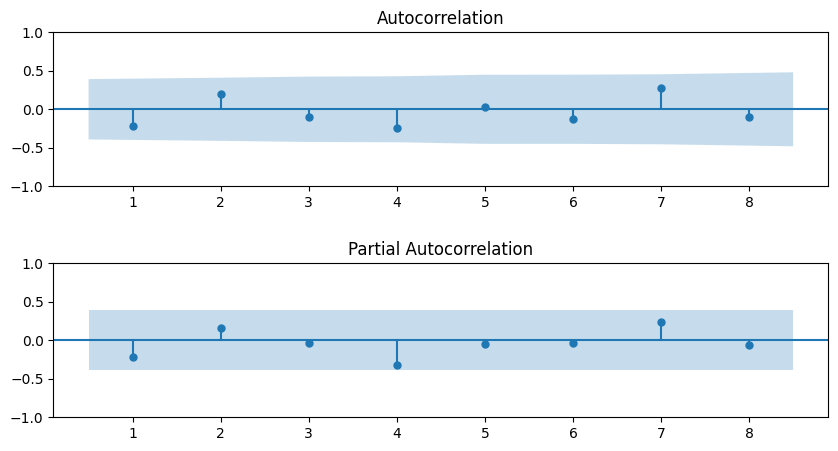

In [36]:
_=qda.Assumptions(regular_point_mean_per_layer).normality()  # Check Normality
_=qda.Assumptions(regular_point_mean_per_layer).independence()  # Check Independence

>Assumptions were met

Design of the I-MR Control Chart

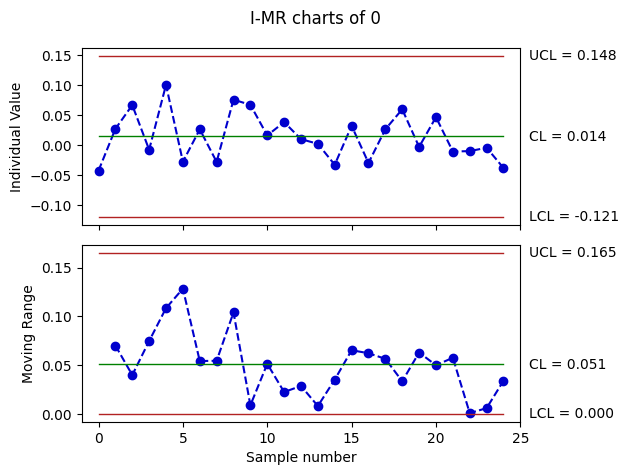

In [37]:
# DataFrame for the residuals
df_SCC_np = pd.DataFrame(regular_point_mean_per_layer, columns=['0'])

# I-MR control chart
df_SCC_IMR_np = qda.ControlCharts.IMR(df_SCC_np, '0')

>Presence of no Out Of Control Points

>The observed control limits appear excessively distant relative to the data point distribution. Consequently, the potential influence of the "hugging effect," a phenomenon where control limits are artificially widened due to specific data characteristics, cannot be excluded and warrants further investigation.

siamo sicuri ch possa esserci un hugging effect? scriviamolo solo se ne siamo super sicuri